In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

import os
import glob

import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

tf.__version__

'2.17.0'

# Data Preview

In [13]:
# !python3 datasets/gen_captcha.py -d --npi=4 -n 6
# !python3 datasets/base.py ./images/char-4-epoch-6/

In [2]:
DATA_DIR = './images/char-4-epoch-6/train'
H, W, C = 100, 120, 3  # height, width, 3(RGB channels)
N_LABELS = 256
D = 4 # num_per_image

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [4]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.png"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,0123,./images/char-4-epoch-6/train\0123_1489098b-71...
1,0123,./images/char-4-epoch-6/train\0123_3fde0086-93...
2,0123,./images/char-4-epoch-6/train\0123_4b5534d2-b0...
3,0123,./images/char-4-epoch-6/train\0123_b832cb5a-d1...
4,0123,./images/char-4-epoch-6/train\0123_cb1bda69-6e...


# Data Preprocessing

In [5]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 14817, valid count: 6351, test count: 9072


In [6]:
from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

# Model

In [7]:
# from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.models import Model
# from tensorflow.keras.saving import load_model

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

# model = load_model('model.keras')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 98, 118, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,520,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 256)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,626,624 (36.72 MB)

 Trainable params: 9,626,624 (36.72 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [8]:
# from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

# callbacks = [
#     ModelCheckpoint("./model_checkpoint", monitor='val_loss')
# ]


Epoch 1/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 185s 796ms/step - accuracy: 0.0998 - loss: 2.5192 - val_accuracy: 0.3034 - val_loss: 2.0232
Epoch 2/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 50s 217ms/step - accuracy: 0.4810 - loss: 1.4892 - val_accuracy: 0.7225 - val_loss: 0.8421
Epoch 3/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 47s 203ms/step - accuracy: 0.7929 - loss: 0.6668 - val_accuracy: 0.8539 - val_loss: 0.4737
Epoch 4/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 239ms/step - accuracy: 0.8907 - loss: 0.3527 - val_accuracy: 0.8877 - val_loss: 0.3531
Epoch 5/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 54s 234ms/step - accuracy: 0.9413 - loss: 0.1926 - val_accuracy: 0.9086 - val_loss: 0.3062


In [15]:

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=6,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

231/231 ━━━━━━━━━━━━━━━━━━━━ 49s 214ms/step - accuracy: 0.9659 - loss: 0.1098 - val_accuracy: 0.9112 - val_loss: 0.2963


# Result Analysis

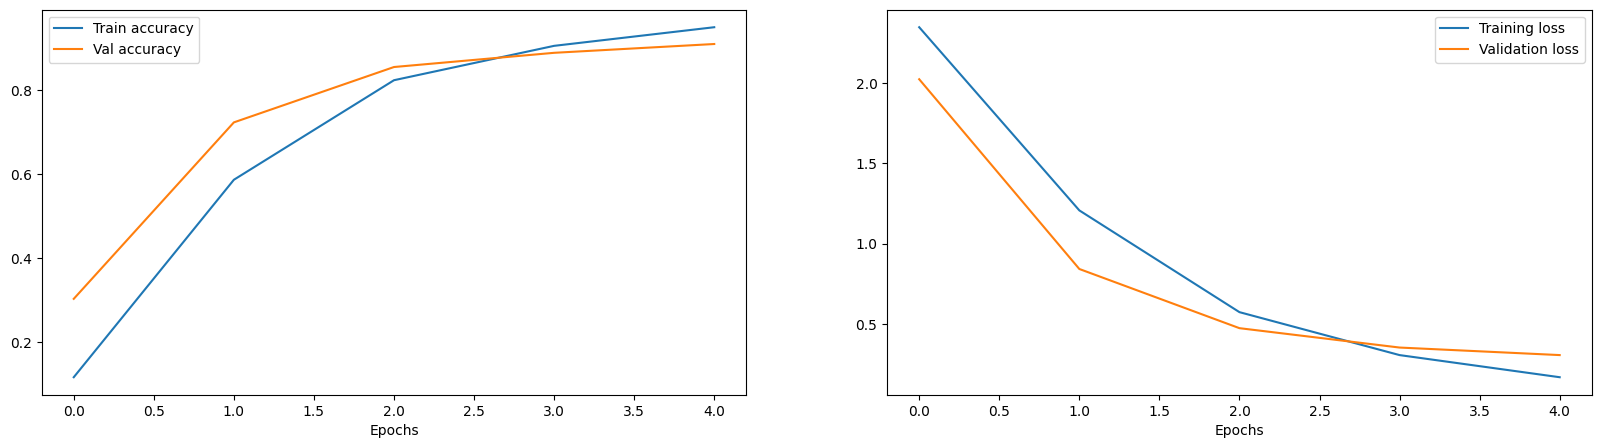

In [9]:


def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()

In [16]:
# evaluate loss and accuracy in test dataset
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9055 - loss: 0.3174


{'loss': 0.313361257314682, 'compile_metrics': 0.9068359136581421}

# Predict and display result

In [17]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

# i have .png image and i want to test that



In [ ]:


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

def predict(filepath):
    # Load and preprocess the image
    im = Image.open(filepath)
    im = im.resize((W, H))  # Resize to match the model's expected input shape
    im = np.array(im) / 255.0  # Normalize the image
    im = np.expand_dims(im, 0)  # Add a batch dimension, making the shape (1, H, W, 3)

    # Predict using the model
    y_pred = model.predict(im)
    
    # Convert the predicted probabilities to class labels
    y_pred = tf.math.argmax(y_pred, axis=-1)
    
    # Convert numerical labels back to characters (assuming it's a character classification task)
    predicted_labels = ''.join([chr(i) for i in y_pred.numpy()[0]])
    
    return predicted_labels

# print(predict('./testimage.png'))

In [12]:
def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

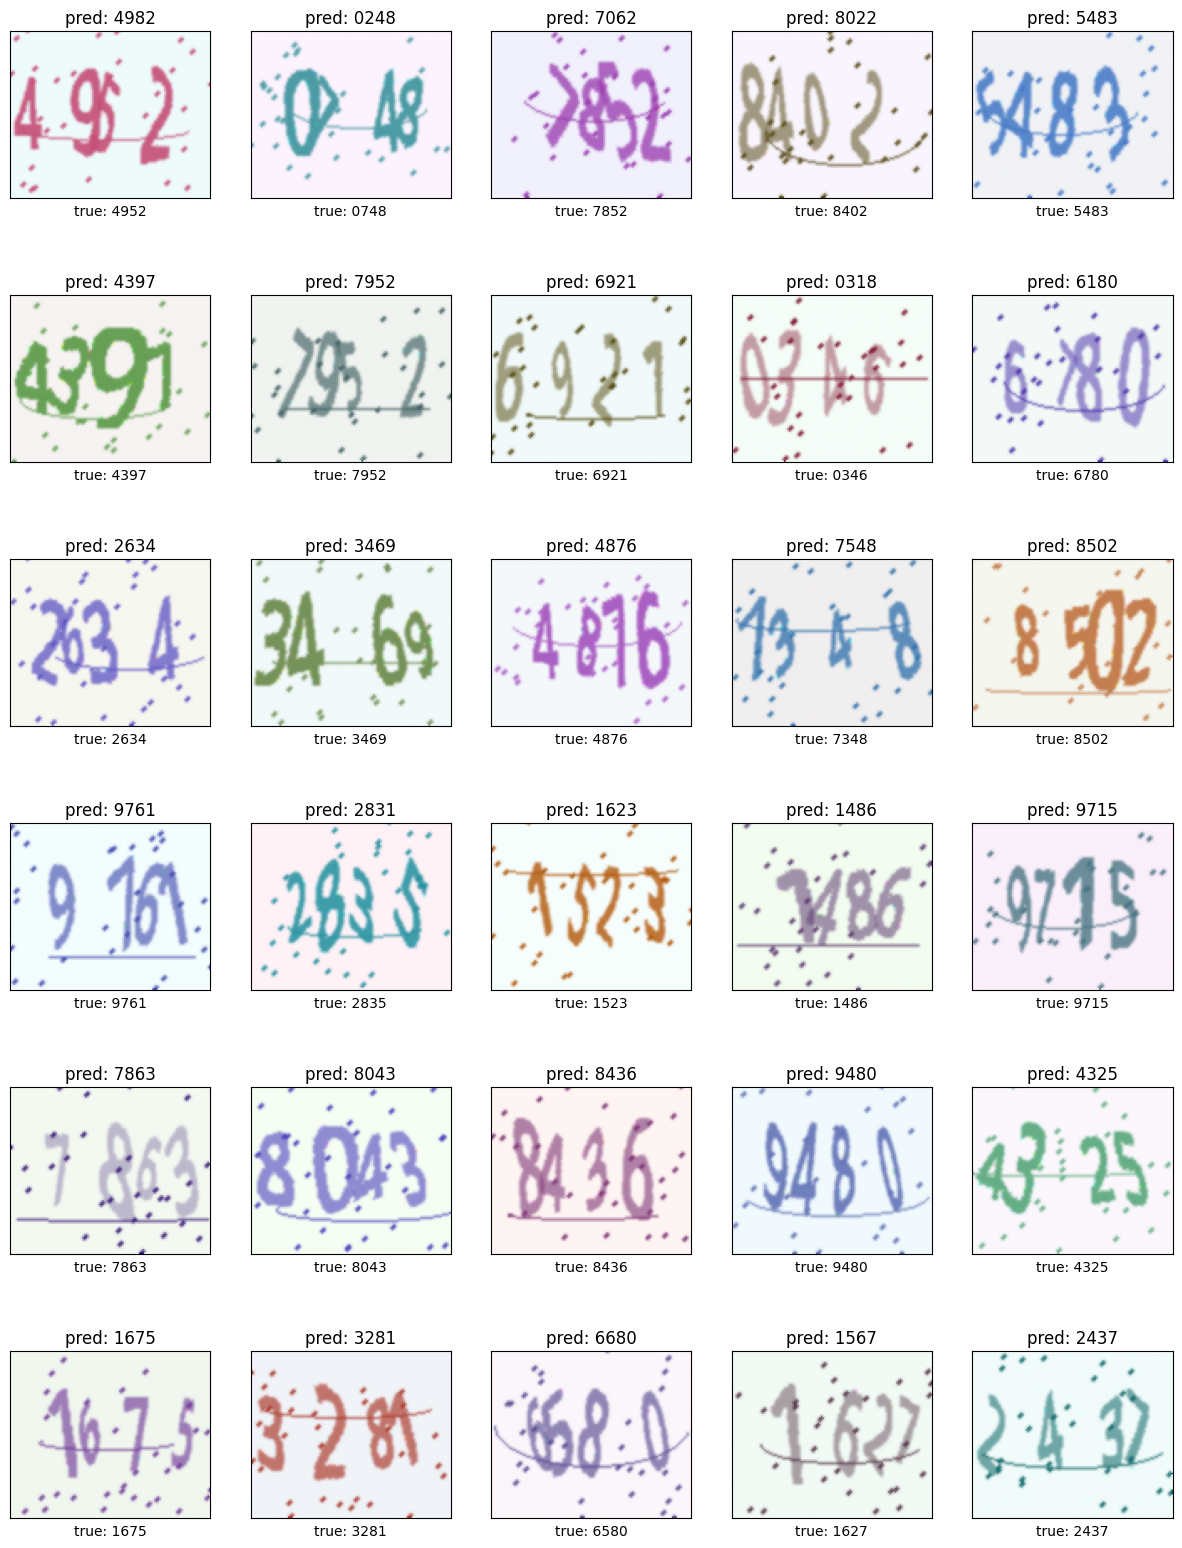

In [18]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [19]:
model.save('final_model.keras')